In [2]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import words, stopwords
from tqdm import tqdm
from collections import defaultdict
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pickle

In [3]:
try:
    with open('humayunnama_occ.pickle', 'rb') as handle:
        occurrences = pickle.load(handle)
except:
    # Extract and tokenize file contents
    f = open('humayunnama.txt', 'r')
    w = []
    for line in tqdm(f, desc="Tokenizing"):
        sentences = sent_tokenize(line)
        for s in sentences:
            ws = word_tokenize(s)
            ws = [word.replace('(', '').replace(')', '').replace('.', '') for word in ws]
            ws = [word[:word.index('—')] if '—' in word else word for word in ws]
            w += [word for word in ws if word != ''] + ['<//>']
    f.close()

    # Get list of names and places where they occur
    occurrences = defaultdict(lambda : [])
    i = 0
    while i < len(w):
        if w[i][0] in "AĀBCDEFGHḤIJKLMNOPQRSṢTUŪVWXYZẔ" and w[i].lower() not in stopwords.words('english'):
            name = []
            beg = i
            while i < len(w) and \
                 (w[i][0] in "AĀBCDEFGHḤIJKLMNOPQRSṢTUŪVWXYZẔ" and w[i] != "'s" or \
                  w[i][:2] == "u-" or \
                  w[i] == "'" or w[i][:2] == "l-" or \
                  w[i] == "a" or \
                  w[i][0] == '-' or i > 0 and w[i-1][-1] == '-'):
                name += [w[i]]
                i += 1
            occurrences[tuple(name)].append((beg, i))
        i += 1

    occurrences = {tuple(word for word in n if word.lower == "beg" or word.lower() not in ["meantime"] + words.words()) : occurrences[n] for n in tqdm(occurrences.keys(), desc='Filtering English words')}
    occurrences = {n : occurrences[n] for n in occurrences if n != tuple()}
    occurrences = {" ".join(n) : occurrences[n] for n in occurrences}
    with open('humayunnama_occ.pickle', 'wb') as handle:
        pickle.dump(occurrences, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
try:
    with open('people.txt', 'r') as f:
        print("Found people.txt, using.")
        all_names = []
        names = []
        mapping = {}
        for line in f:
            n = line[:-1].split(':')
            all_names += n
            names.append(n[0])
            if len(n) > 1:
                for name in n[1:]:
                    mapping[name] = n[0]
        
    for name in all_names:
        if name in mapping:
            #print(f"Shifting {name} to {mapping[name]}")
            occurrences[mapping[name]] += occurrences[name]
            del occurrences[name]
            

except FileNotFoundError:
    names = list(occurrences.keys())
    with open('names.txt', 'r') as f:
        for name in names: f.write(f"{name}\n")
    print("Using names including non-people!")

Found people.txt, using.


In [5]:
# For all pairs of words, find the number of times they occur within W words of each other.
W = 5
cooccurrence = {}
for i in tqdm(range(len(names)), desc="Extracting cooccurrences"):
    name1 = names[i]
    positions1 = occurrences[name1]
    for name2 in names[:i] + names[i+1:]:
        positions2 = occurrences[name2]
        distances = [min(abs(b1-e2), abs(b2-e1)) for b1, e1 in positions1 for b2, e2 in positions2]
        cooccurrence[(name1, name2)] = sum(1 for d in distances if d <= W)

Extracting cooccurrences:   0%|          | 0/388 [00:00<?, ?it/s]

Extracting cooccurrences: 100%|██████████| 388/388 [00:00<00:00, 1921.72it/s]


In [11]:
# Make an adjacency matrix for numpy.
n = len(names)
adjacency = np.zeros((n, n), dtype=int)
for i in range(n):
    for j in range(n):
        val = 0
        val += cooccurrence[(names[i], names[j])] if (names[i], names[j]) in cooccurrence else 0
        val += cooccurrence[(names[j], names[i])] if (names[j], names[i]) in cooccurrence else 0
        adjacency[i, j] = adjacency[j, i] = val

u, s, vh = np.linalg.svd(adjacency)
print(sum(s[:150])/sum(s)) # ~ 0.79
embeddings = u[:, :150]
embeddings = embeddings / np.linalg.norm(embeddings, axis=-1, keepdims = True)

0.7971550994202705


/var/folders/7s/t502n_qs6zg3d8hynhr0prpm0000gn/T/ipykernel_70829/3365292147.py:14: RuntimeWarning: invalid value encountered in divide
  embeddings = embeddings / np.linalg.norm(embeddings, axis=-1, keepdims = True)


/opt/homebrew/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 61699 (\uf103) missing from current font.
  fig.canvas.draw()


<Axes: >

/Users/abhinavmenon/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 61699 (\uf103) missing from current font.
  func(*args, **kwargs)
/Users/abhinavmenon/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 61699 (\uf103) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


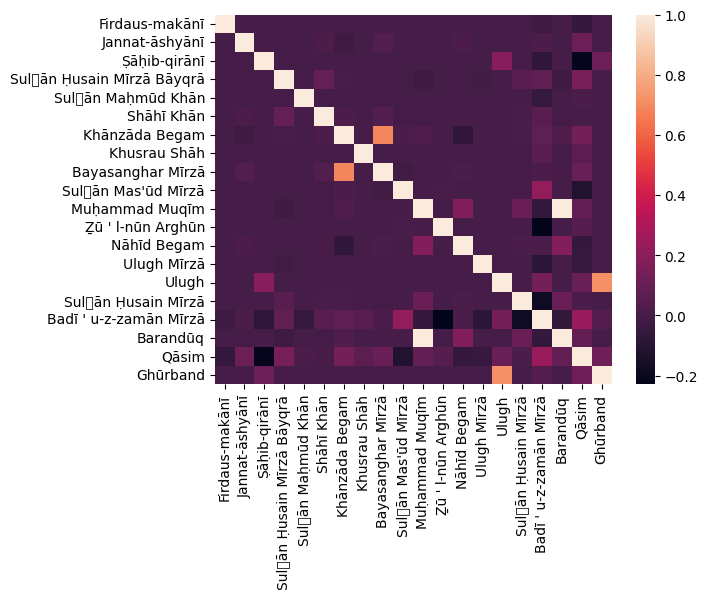

In [12]:
distances = embeddings @ embeddings.transpose()
seaborn.heatmap(distances[:20, :20], xticklabels=names[:20], yticklabels=names[:20])

In [9]:
# Collapse name1-name2 and name2-name1
for (n1, n2) in [(n1, n2) for n1 in names for n2 in names]:
    if (n1 <= n2): continue
    cooccurrence[(n2, n1)] += cooccurrence[(n1, n2)]
    del cooccurrence[(n1, n2)]

In [10]:
# Construct graph
G = nx.Graph()
G.add_nodes_from(names)
for (n1, n2) in cooccurrence:
    if cooccurrence[(n1, n2)] > 0:
        G.add_edge(n1, n2)

In [11]:
# Remove nodes without edges
for n in names:
    if len(G.edges(n)) == 0:
        G.remove_node(n)

In [18]:
# Consider only the largest connected component
components = [G.subgraph(c).copy() for c in sorted(nx.connected_components(G), key=len, reverse=True)]

component = components[0]
nx.draw(component, nx.spring_layout(component), node_size=2, with_labels=True, font_size=5)
plt.show()

NetworkXException: G is not planar.

In [ ]:
# Compute and check distribution of centrality.
# We should probably use >= (or >) 0.02 to threshold.
centrality = nx.degree_centrality(component)
centrality = sorted(centrality.items(), key = lambda p : p[1], reverse=True)
plt.hist([c for name, c in centrality])
plt.show()

In [ ]:
t = 0.02
main_names = nx.Graph.subgraph(component, [name for name, c in centrality if c >= t])
nx.draw(main_names, nx.planar_layout(main_names), node_size=2, with_labels=True, font_size=5)
plt.show()